In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from patsy import dmatrices
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
from matplotlib.pyplot import legend, figure

### Here you will find: 

- Initial data summary
- Multivariable linear regression assumption test.
- MMM with daily data
- MMM with Weekly data.
- Log-log model.

## Data Summary

In [3]:
# Load the model data
df = pd.read_csv('B.csv',dtype={
    'Revenue': np.float64,
    'Google SA': np.float64,
    'Microsoft SA': np.float64,
    'Facebook SA': np.float64,
    'Facebook BA': np.float64,
}, parse_dates=['Date'])
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Year_Month'] = df['Year'].astype(str) + '-' + df['Month'].astype(str)
df['WeekNumber'] = pd.DatetimeIndex(df['Date']).week
df.head()

/var/folders/k2/8mbjx2mx4jg3bkxxj6m1xbs40000gn/T/ipykernel_18723/404335566.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['WeekNumber'] = pd.DatetimeIndex(df['Date']).week


,Date,Revenue,Google SA,Microsoft SA,Facebook SA,Facebook BA,Year,Month,Year_Month,WeekNumber
0,2019-01-01,335.38,123.99,0.0,0.0,0.0,2019,1,2019-1,1
1,2019-01-02,855.65,126.01,0.0,0.0,0.0,2019,1,2019-1,1
2,2019-01-03,1002.28,134.67,0.0,0.0,0.0,2019,1,2019-1,1
3,2019-01-04,539.95,126.18,0.0,0.0,0.0,2019,1,2019-1,1
4,2019-01-05,202.41,128.06,0.0,0.0,0.0,2019,1,2019-1,1


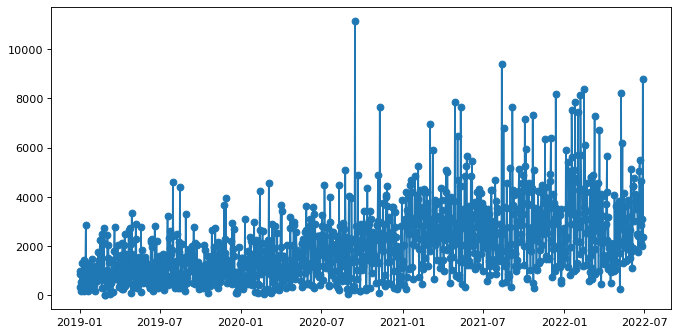

In [4]:
figure(figsize=(10, 5), dpi=80)
plt.plot(df['Date'], df['Revenue'], marker='o')
plt.show()

## Data Quality and Analysis

### NaN Values

In [5]:
df[df != 0.0].drop('Year_Month', 1).isna().groupby(df.Year_Month, sort=False).sum().reset_index()

/var/folders/k2/8mbjx2mx4jg3bkxxj6m1xbs40000gn/T/ipykernel_18723/742069122.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df[df != 0.0].drop('Year_Month', 1).isna().groupby(df.Year_Month, sort=False).sum().reset_index()


,Year_Month,Date,Revenue,Google SA,Microsoft SA,Facebook SA,Facebook BA,Year,Month,WeekNumber
0,2019-1,0,0,0,31,31,31,0,0,0
1,2019-2,0,1,0,28,28,28,0,0,0
2,2019-3,0,0,0,31,31,31,0,0,0
3,2019-4,0,0,0,30,30,30,0,0,0
4,2019-5,0,0,0,31,31,31,0,0,0
5,2019-6,0,0,0,29,30,30,0,0,0
6,2019-7,0,0,0,0,31,31,0,0,0
7,2019-8,0,0,0,0,31,31,0,0,0
8,2019-9,0,0,0,0,30,30,0,0,0
9,2019-10,0,0,0,0,31,25,0,0,0


In [6]:
df = df.fillna(0)
df.head()

,Date,Revenue,Google SA,Microsoft SA,Facebook SA,Facebook BA,Year,Month,Year_Month,WeekNumber
0,2019-01-01,335.38,123.99,0.0,0.0,0.0,2019,1,2019-1,1
1,2019-01-02,855.65,126.01,0.0,0.0,0.0,2019,1,2019-1,1
2,2019-01-03,1002.28,134.67,0.0,0.0,0.0,2019,1,2019-1,1
3,2019-01-04,539.95,126.18,0.0,0.0,0.0,2019,1,2019-1,1
4,2019-01-05,202.41,128.06,0.0,0.0,0.0,2019,1,2019-1,1


### Revenue Behaviour

In [7]:
df[['Revenue', 'Year']].groupby('Year').describe()

Revenue                                                                 \
       count         mean          std     min       25%       50%      75%   
Year                                                                          
2019   365.0  1144.121507   747.627470    0.00   618.020   982.600  1469.31   
2020   366.0  1720.204426  1199.136635   50.78   853.475  1568.560  2376.11   
2021   365.0  2802.774795  1494.728810  266.08  1674.320  2740.440  3607.21   
2022   180.0  3062.914389  1723.064585  249.67  1861.245  2719.045  4007.43   

                
           max  
Year            
2019   4611.68  
2020  11134.70  
2021   9381.27  
2022   8768.26

In [9]:
df[['Revenue', 'Year']].groupby('Year').agg(['sum'])

,Revenue
,sum
Year,
2019,417604.35
2020,629594.82
2021,1023012.80
2022,551324.59


<AxesSubplot:title={'center':'Revenue'}, xlabel='[Year]'>

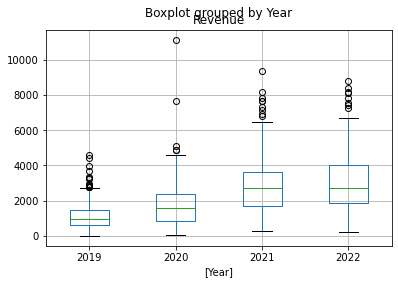

In [10]:
df[['Revenue', 'Year']].boxplot(by='Year')

Conclusion

* 2019 Investment into marketing channels began at the end of the year
* 2020 because of covid has a lot of nuisance variables that we cannot account for
* 2022 we don't have enough data.
* 2020 there are several periods without channel investment (probably because of COVID)

Focus the analysis on 2021 data for now and see how later how the model holds in other periods

### From this point forward just information from 2021 will be described

We are accounting for too few variables in the MMM model. By using 2021 data only, we want to reduce the risk of observation external behavior not related to variables that we can measure/control.

In [12]:
df_2021=df[df['Year']==2021].sort_values("Date").reset_index(drop=True)
df_2021.head()

,Date,Revenue,Google SA,Microsoft SA,Facebook SA,Facebook BA,Year,Month,Year_Month,WeekNumber
0,2021-01-01,1385.56,650.11,91.60,0.0,0.0,2021,1,2021-1,53
1,2021-01-02,1186.41,0.20,0.00,0.0,0.0,2021,1,2021-1,53
2,2021-01-03,433.67,3.33,4.23,0.0,0.0,2021,1,2021-1,53
3,2021-01-04,2060.49,594.06,145.88,0.0,0.0,2021,1,2021-1,1
4,2021-01-05,3058.25,537.06,162.67,0.0,0.0,2021,1,2021-1,1


## Channel Investment Behaviour

In [13]:
df_2021[["Google SA","Microsoft SA","Facebook SA","Facebook BA"]].agg(['sum'])

,Google SA,Microsoft SA,Facebook SA,Facebook BA
sum,180310.16,41654.62,5653.5,3657.89


### Variable Correlations

In [14]:
corr = df_2021[["Google SA","Microsoft SA","Facebook SA","Facebook BA"]].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/k2/8mbjx2mx4jg3bkxxj6m1xbs40000gn/T/ipykernel_18723/3143952813.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Google SA,Microsoft SA,Facebook SA,Facebook BA
Google SA,1.00,0.83,0.02,0.01
Microsoft SA,0.83,1.00,0.02,0.01
Facebook SA,0.02,0.02,1.00,-0.63
Facebook BA,0.01,0.01,-0.63,1.00


In [16]:
pca = PCA()
pca.fit(df_2021[["Google SA","Microsoft SA","Facebook SA","Facebook BA"]])
pca.explained_variance_ratio_ 

array([0.97205542, 0.02040107, 0.0064717 , 0.00107181])

## Feature Importance

In [17]:
df_2021.isnull().any()

Date            False
Revenue         False
Google SA       False
Microsoft SA    False
Facebook SA     False
Facebook BA     False
Year            False
Month           False
Year_Month      False
WeekNumber      False
dtype: bool

<AxesSubplot:>

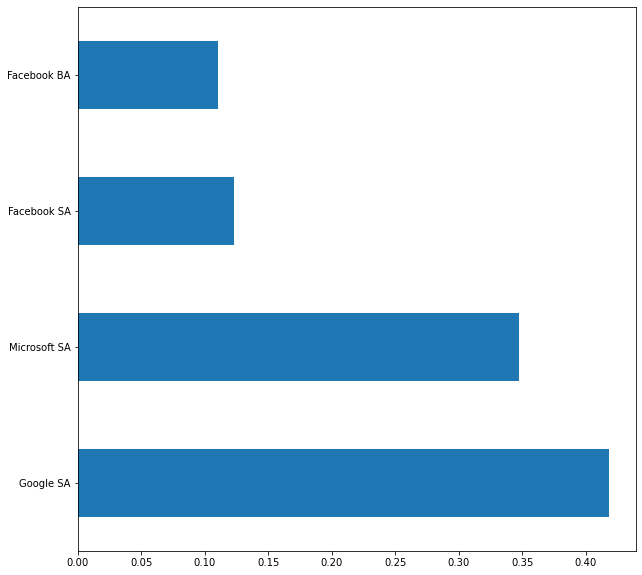

In [18]:
df_fi = df_2021.drop(['Date','Year','Month','Year_Month','WeekNumber'], axis=1)
X = df_fi.loc[:, df_fi.columns != 'Revenue']
y = df_fi['Revenue']
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

In [19]:
df[["Google SA","Microsoft SA","Facebook SA","Facebook BA"]].agg(['sum'])

,Google SA,Microsoft SA,Facebook SA,Facebook BA
sum,509440.27,75717.98,7611.15,4108.45


In [20]:
df[['Revenue','Year','Google SA','Microsoft SA','Facebook SA','Facebook BA']].groupby('Year').agg(['sum'])

,Revenue,Google SA,Microsoft SA,Facebook SA,Facebook BA
,sum,sum,sum,sum,sum
Year,,,,,
2019,417604.35,92110.24,3037.42,0.00,20.00
2020,629594.82,146794.58,20072.63,0.00,50.00
2021,1023012.80,180310.16,41654.62,5653.50,3657.89
2022,551324.59,90225.29,10953.31,1957.65,380.56


Google has received by far the most amount, and has been running for the longest time which is likely to be the 
most important feature for these reasons. 
Microsoft has received some funding after a significant increase in 2020 and is the second most important feature
Both Facebooks have received very little funding and this is reflected in their importance. 

### Normality Tets

In [22]:
from scipy.stats import normaltest
for column in ["Google SA","Microsoft SA","Facebook SA","Facebook BA","Revenue"]:
    print("{}: {}".format(column, normaltest(df_2021[column])))

Google SA: NormaltestResult(statistic=55.51194241612072, pvalue=8.825409472227667e-13)
Microsoft SA: NormaltestResult(statistic=144.345527241449, pvalue=4.5265468094647864e-32)
Facebook SA: NormaltestResult(statistic=73.27018680124976, pvalue=1.2290826612590565e-16)
Facebook BA: NormaltestResult(statistic=46.811182613943714, pvalue=6.84038978391047e-11)
Revenue: NormaltestResult(statistic=55.03411917492856, pvalue=1.1207090086581136e-12)


### Regression Fit 

In [28]:
df_2021 = df_2021.rename(columns={
    "Google SA": "gSA","Microsoft SA": "mSA","Facebook SA": "fSA","Facebook BA": "fBA"
})

### Daily Regressions

In [29]:
lm_day_model = sm.ols(formula="Revenue~gSA+"
                          "mSA+"
                          "fSA+"
                          "fBA", data=df_2021).fit()
print(lm_day_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     50.67
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           8.08e-34
Time:                        12:59:46   Log-Likelihood:                -3104.0
No. Observations:                 365   AIC:                             6218.
Df Residuals:                     360   BIC:                             6237.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1117.4663    176.390      6.335      0.0

### Multicollinearity Test

VIF and multicollinearity->https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

In [19]:
y, X = dmatrices("Revenue~gSA+mSA+fSA+fBA", df_2021.rename(columns={
        "Google SA":'gSA', 'Microsoft SA':'mSA', 'Favebook SA': "fSA", "Facebook BA": "fBA"
}), return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,4.142905,Intercept
1,2.815379,gSA
2,3.450571,mSA
3,1.257618,fSA
4,1.254880,fBA


### Predictions for the Daily Model

2021:

In [30]:
predictions_daily = pd.DataFrame({
    'Predictions':lm_day_model.predict(df_2021[['gSA','mSA','fSA','fBA']]),
    'Revenue': df_2021['Revenue'],
    'Date': df_2021['Date']
})
predictions_daily['ErrorAbs'] = abs(predictions_daily['Predictions'] - predictions_daily['Revenue'])
predictions_daily= predictions_daily.set_index('Date')
predictions_daily.head()

,Predictions,Revenue,ErrorAbs
Date,,,
2021-01-01,3061.334479,1385.56,1675.774479
2021-01-02,1117.934986,1186.41,68.475014
2021-01-03,1144.685098,433.67,711.015098
2021-01-04,3179.132262,2060.49,1118.642262
2021-01-05,3122.626945,3058.25,64.376945


In [21]:
mape(predictions_daily['Predictions'], predictions_daily['Revenue'])

0.4142333296612384

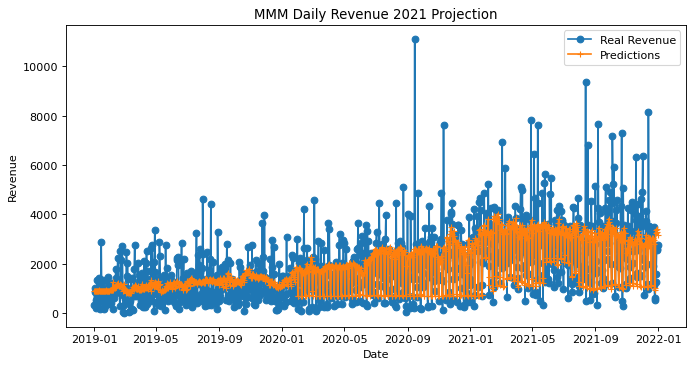

In [22]:
figure(figsize=(10, 5), dpi=80)
plt.plot(predictions_daily["Revenue"], marker='o')
plt.plot(predictions_daily["Predictions"], marker='+')

# Labelling
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("MMM Daily Revenue 2021 Projection")
plt.legend(['Real Revenue', 'Predictions'])
# Display

plt.show()

2022:

In [31]:
df_2022=df[df['Year']==2022].rename(columns={
   "Google SA":'gSA', 'Microsoft SA':'mSA', 'Facebook SA': "fSA", "Facebook BA": "fBA"
}).reset_index(drop=True)
predictions_daily = pd.DataFrame({
    'Predictions':lm_day_model.predict(df_2022[['gSA','mSA','fSA','fBA']]),
    'Revenue': df_2022['Revenue'],
    'Date': df_2022['Date']
})
predictions_daily['ErrorAbs'] = abs(predictions_daily['Predictions'] - predictions_daily['Revenue'])
predictions_daily= predictions_daily.set_index('Date')
predictions_daily.head()

,Predictions,Revenue,ErrorAbs
Date,,,
2022-01-01,1398.157423,1820.40,422.242577
2022-01-02,1422.870121,2377.88,955.009879
2022-01-03,2921.702866,1777.99,1143.712866
2022-01-04,3123.929110,1530.01,1593.919110
2022-01-05,3139.515527,5911.33,2771.814473


In [25]:
predictions_daily.to_csv('B_NEW_Daily_2022_predvact.csv')

In [26]:
mape(predictions_daily['Predictions'], predictions_daily['Revenue'])

0.5841115474679215

### Predictions for the Weekly Model

Transforming 2021 data to be Weekly:

In [27]:
df_2021_week=df_2021[['Revenue', 'gSA','mSA','fSA','fBA','WeekNumber']]
df_2021_week=df_2021_week[df_2021_week['WeekNumber'] < 52].groupby('WeekNumber').agg([sum])
df_2021_week =  df_2021_week[['Revenue', 'gSA','mSA','fSA','fBA']].reset_index(drop=True).T.reset_index(drop=True).T.rename(columns={
    0: 'Revenue',
    1: 'gSA',
    2: 'mSA',
    3: 'fSA',
    4: 'fBA',
})
df_2021_week['WeekNumber']=df_2021[df_2021['WeekNumber'] < 52].groupby('WeekNumber').count().reset_index()['WeekNumber']
df_2021_week.tail()

,Revenue,gSA,mSA,fSA,fBA,WeekNumber
46,46220.37,9632.85,1591.90,157.16,10.12,47
47,57027.60,9712.33,1507.41,71.28,49.74,48
48,39105.57,9457.71,1381.26,41.97,50.36,49
49,49393.15,8762.36,1361.89,49.46,51.52,50
50,33637.53,7940.65,1275.76,106.65,29.23,51


Transforming 2022 data to be Weekly:

In [32]:
df_2022_week=df_2022[['Revenue', 'gSA','mSA','fSA','fBA','WeekNumber']]
df_2022_week=df_2022_week[df_2022_week['WeekNumber'] < 52].groupby('WeekNumber').agg([sum])
df_2022_week =  df_2022_week[['Revenue', 'gSA','mSA','fSA','fBA']].reset_index(drop=True).T.reset_index(drop=True).T.rename(columns={
    0: 'Revenue',
    1: 'gSA',
    2: 'mSA',
    3: 'fSA',
    4: 'fBA',
})
df_2022_week['WeekNumber']=df_2022[df_2022['WeekNumber'] < 52].groupby('WeekNumber').count().reset_index()['WeekNumber']
df_2022_week.head()

,Revenue,gSA,mSA,fSA,fBA,WeekNumber
0,18577.70,3562.09,560.55,160.87,0.0,1
1,25153.57,3604.29,481.86,123.84,0.0,2
2,29176.52,4589.94,386.94,131.60,0.0,3
3,25474.15,5106.01,338.86,146.66,0.0,4
4,25932.68,4368.48,292.46,127.48,0.0,5


Fitting the model:

In [37]:
lm_week_model = sm.ols(formula="Revenue~gSA+"
                          "mSA+"
                          "fSA+"
                          "fBA", data=df_2021_week).fit()
print(lm_week_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     7.869
Date:                Thu, 14 Jul 2022   Prob (F-statistic):           6.42e-05
Time:                        13:58:12   Log-Likelihood:                -502.29
No. Observations:                  51   AIC:                             1015.
Df Residuals:                      46   BIC:                             1024.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9414.0206   6351.350      1.482      0.1

### Multicollinearity Test

In [38]:
y, X = dmatrices("Revenue~gSA+mSA+fSA+fBA", df_2021_week, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,88.399486,Intercept
1,1.801362,gSA
2,2.250178,mSA
3,1.088401,fSA
4,1.337199,fBA


2021:

In [39]:
predictions_weekly = pd.DataFrame({
    'Predictions':lm_week_model.predict(df_2021_week[['gSA','mSA','fSA','fBA']]),
    'Revenue': df_2021_week['Revenue'],
    'WeekNumber': df_2021_week['WeekNumber']
})
predictions_weekly['ErrorAbs'] = abs(predictions_weekly['Predictions'] - predictions_weekly['Revenue'])
predictions_weekly.head()

,Predictions,Revenue,WeekNumber,ErrorAbs
0,28677.139533,26667.74,1,2009.399533
1,31715.510373,31938.84,2,223.329627
2,34239.371560,39246.23,3,5006.858440
3,40288.838239,33628.45,4,6660.388239
4,35310.336191,36334.21,5,1023.873809


In [40]:
mape(predictions_weekly['Predictions'], predictions_weekly['Revenue'])


0.0928316523022144

2022:

In [41]:
predictions_weekly = pd.DataFrame({
    'Predictions':lm_week_model.predict(df_2022_week[['gSA','mSA','fSA','fBA']]),
    'Revenue': df_2022_week['Revenue'],
    'WeekNumber': df_2022_week['WeekNumber']
})
predictions_weekly['ErrorAbs'] = abs(predictions_weekly['Predictions'] - predictions_weekly['Revenue'])
predictions_weekly.head()

,Predictions,Revenue,WeekNumber,ErrorAbs
0,21938.924817,18577.70,1,3361.224817
1,21667.427263,25153.57,2,3486.142737
2,23459.667733,29176.52,3,5716.852267
3,24347.228975,25474.15,4,1126.921025
4,22197.925277,25932.68,5,3734.754723


In [42]:
predictions_weekly.to_csv('D_NEW_Weekly_2022_predvact.csv')

In [43]:
mape(predictions_weekly['Predictions'], predictions_weekly['Revenue'])

0.1890660439679819